In [28]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

# define els_obs as an object containing x_normals and y_normals with same as size as n_pts
class els_normals:
    def __init__(self, els, n_pts):
        x_normals = els.x_normals
        y_normals = els.y_normals
        x_shears = els.x_shears
        y_shears = els.y_shears

        self.x_normals = np.zeros(n_pts * len(x_normals))
        self.y_normals = np.zeros(n_pts * len(x_normals))
        self.x_normals[0:n_pts] = x_normals[0]
        self.y_normals[0:n_pts] = y_normals[0]
        self.x_normals[n_pts : 2 * n_pts] = x_normals[1]
        self.y_normals[n_pts : 2 * n_pts] = y_normals[1]
        self.x_normals[2 * n_pts :] = x_normals[2]
        self.y_normals[2 * n_pts :] = y_normals[2]

        self.x_shears = np.zeros(n_pts * len(x_normals))
        self.y_shears = np.zeros(n_pts * len(x_normals))
        self.x_shears[0:n_pts] = x_shears[0]
        self.y_shears[0:n_pts] = y_shears[0]
        self.x_shears[n_pts : 2 * n_pts] = x_shears[1]
        self.y_shears[n_pts : 2 * n_pts] = y_shears[1]
        self.x_shears[2 * n_pts :] = x_shears[2]
        self.y_shears[2 * n_pts :] = y_shears[2]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


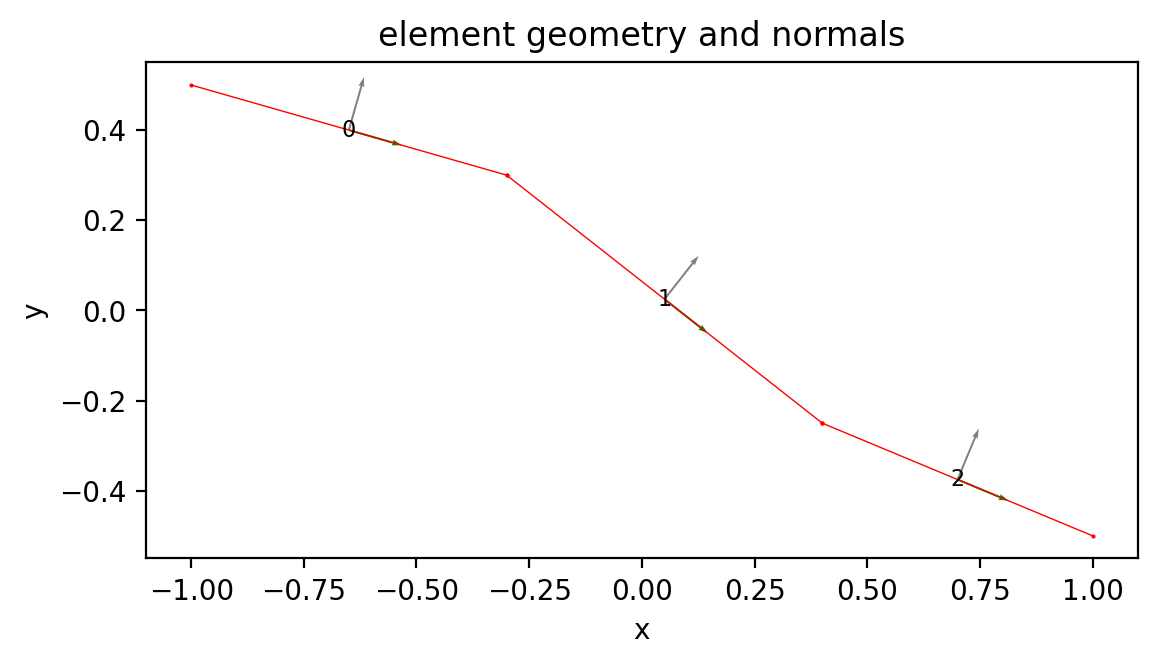

In [29]:
els = bemcs.initialize_els()
# els.x1 = np.array([-1.0, 0.0, 0.0])
# els.y1 = np.array([0.5, 0.5, -0.5])
# els.x2 = np.array([0.0, 0.0, 1.0])
# els.y2 = np.array([0.5, -0.5, -0.5])

els.x1 = np.array([-1.0, -0.3, 0.4])
els.y1 = np.array([0.5, 0.3, -0.25])
els.x2 = np.array([-0.3, 0.4, 1.0])
els.y2 = np.array([0.3, -0.25, -0.5])

# Slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_vector_x = np.array([0.3, 0.8, 0])
slip_vector_y = np.array([0.8, 0.0, -0.9])
# slip_vector_x = np.random.rand(3)
# slip_vector_y = np.random.rand(3)

bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

In [30]:
# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
design_mat = np.zeros((n_els * stride, n_els * stride))

# Set boundary conditions
# Slip -or- slip gradients at the boundaries (we set them to 0 here)
bc_vec = np.zeros((n_els * stride))
bc_vec[0] = 0.0
bc_vec[1] = 0.0
bc_vec[-1] = 0.0
bc_vec[-2] = 0.0
bc_vec[2::stride] = slip_vector_x
bc_vec[3::stride] = slip_vector_y

# Populate design matrix
# Boundary nodes
design_mat[0:2, :] = slip_mat[0:2]
design_mat[-2:, :] = slip_mat[-2:, :]

# Patch center nodes
design_mat[2::stride, :] = slip_mat[2::stride, :]
design_mat[3::stride, :] = slip_mat[3::stride, :]

# Overlapping interior nodes (apply slip continuity and smoothness)
# Slip continuity (x component)
design_mat[4:-7:stride, :] = slip_mat[4:-7:stride, :] - slip_mat[6:-5:stride, :]

# Slip continuity (y component)
design_mat[5:-6:stride, :] = slip_mat[5:-6:stride, :] - slip_mat[7:-4:stride, :]

# Smoothness
# x component
design_mat[6:-5:stride, :] = (
    slip_gradient_mat[4:-7:stride, :] - slip_gradient_mat[6:-5:stride, :]
)
# y component
design_mat[7:-4:stride, :] = (
    slip_gradient_mat[5:-6:stride, :] - slip_gradient_mat[7:-4:stride, :]
)

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.inv(design_mat) @ bc_vec

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

# Plot Slip along the fault

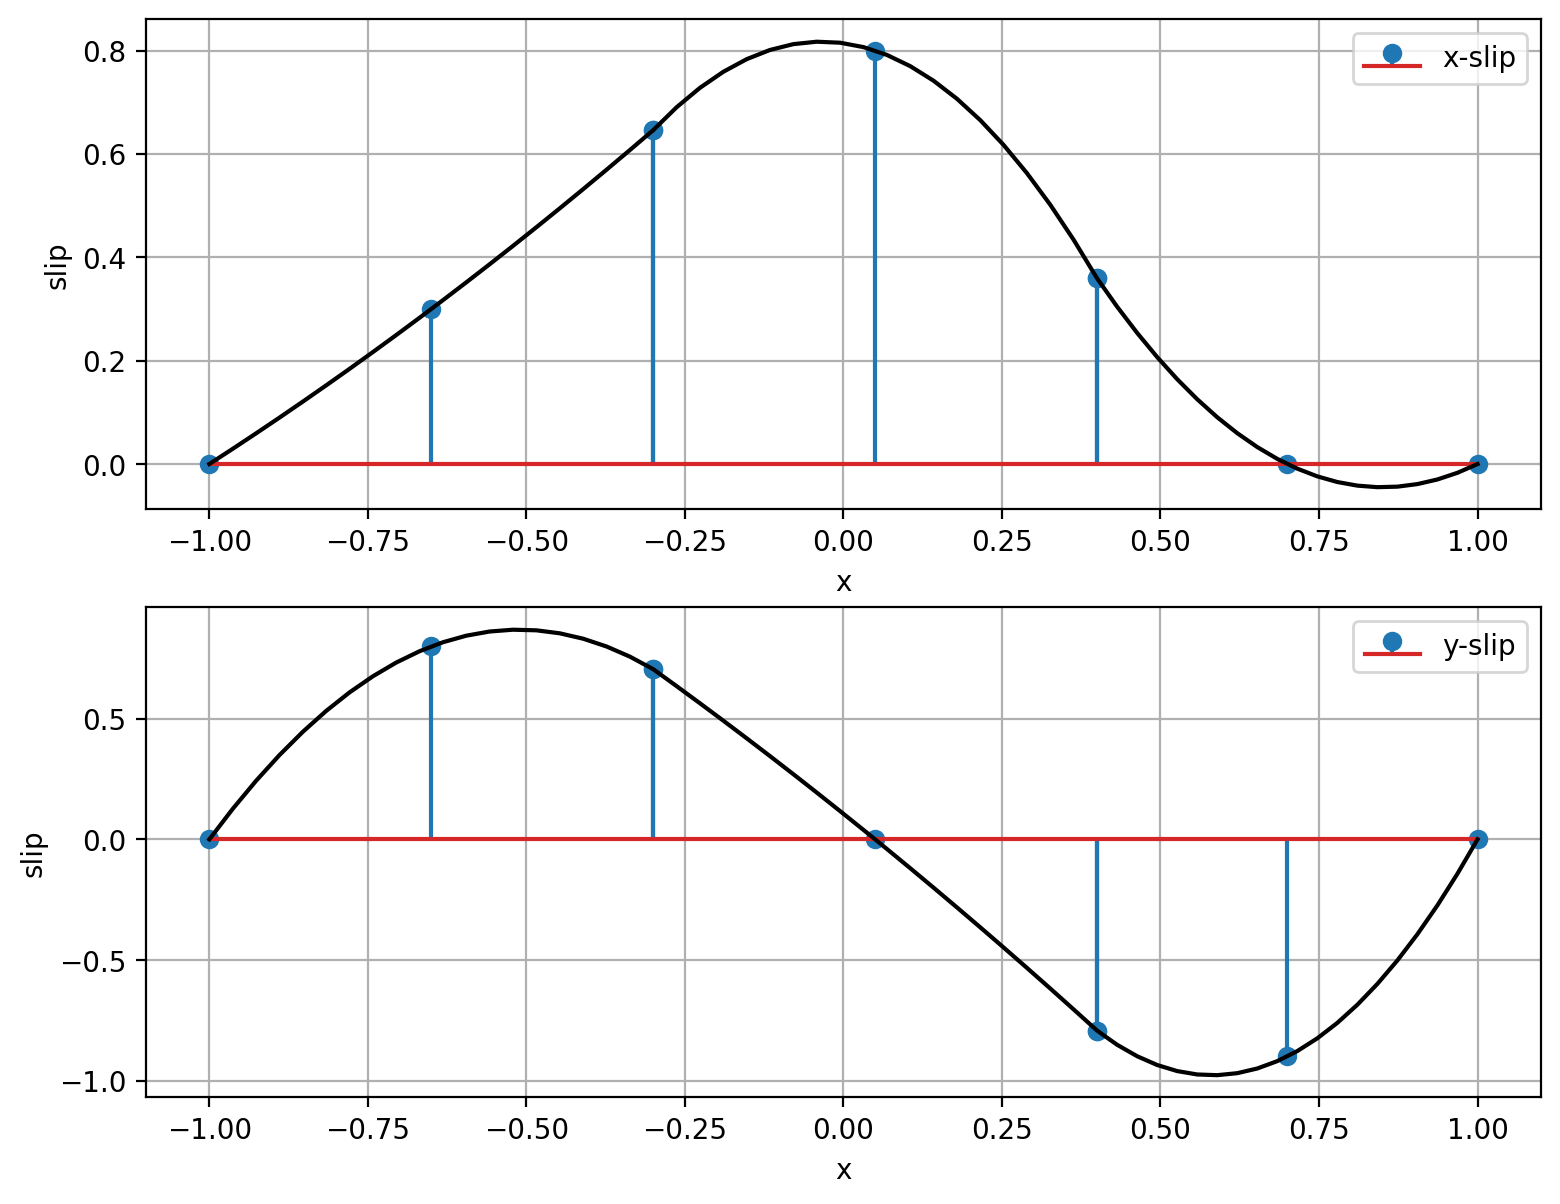

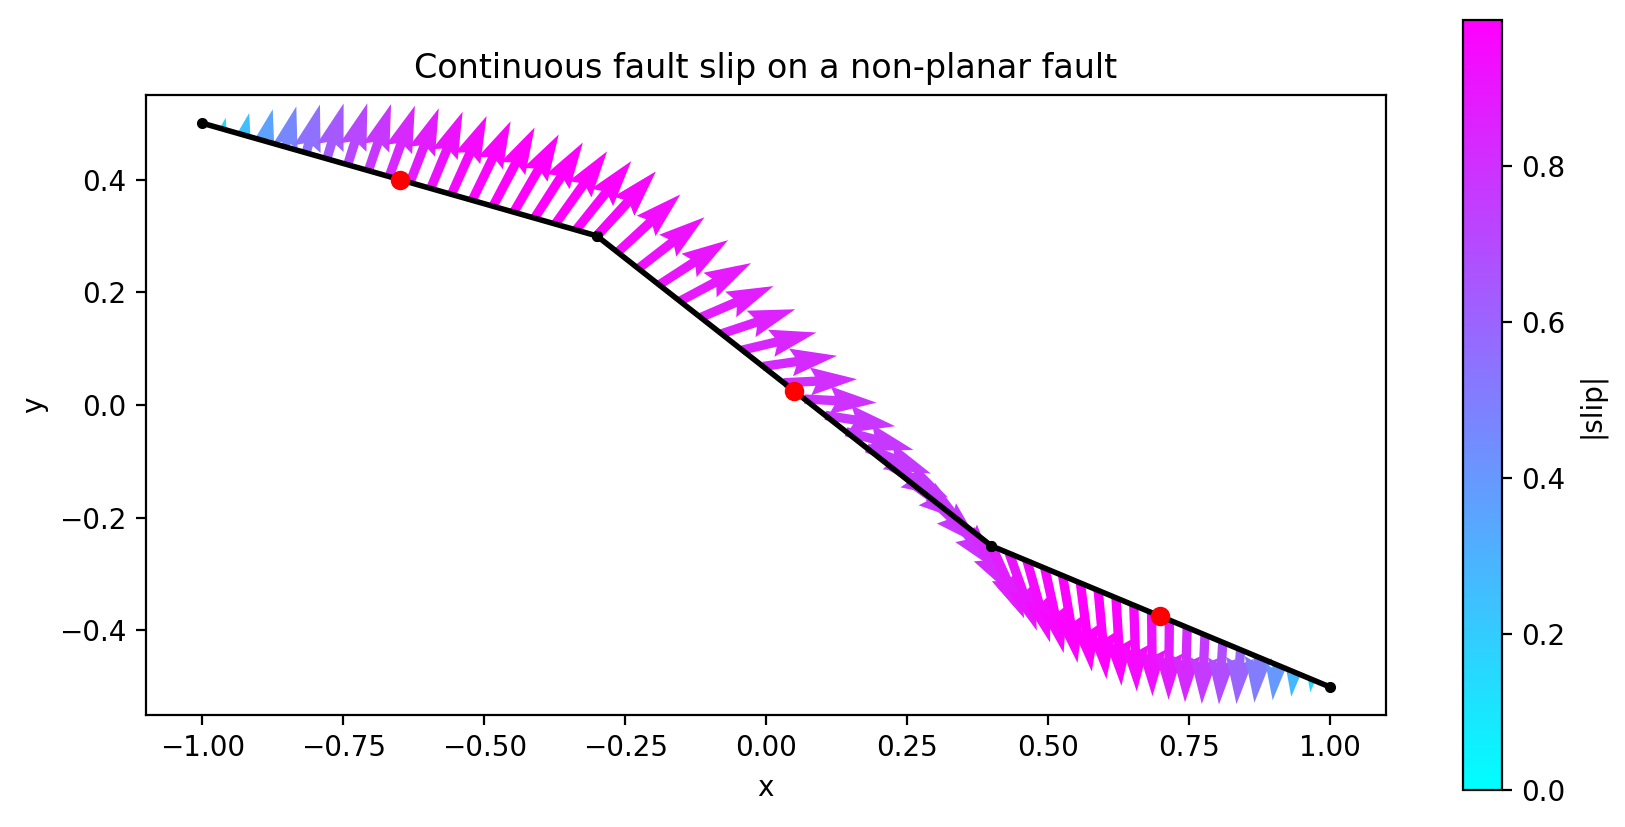

In [31]:
# provide number of points per fault element
n_eval = 20

# calculate slip at all nodes
x_nodes = np.zeros((3 * n_els, 1))
x_nodes[0::3, 0] = els.x1
x_nodes[2::3, 0] = els.x2
x_nodes[1::3, 0] = els.x_centers
fault_slip = slip_mat @ coeffs
fault_slip_x_nodes = fault_slip[0::2]
fault_slip_y_nodes = fault_slip[1::2]

# calculate slip as a continuous function
fault_slip_s = np.zeros(n_els * n_eval)
fault_slip_n = np.zeros(n_els * n_eval)
fault_slip_x = np.zeros(n_els * n_eval)
fault_slip_y = np.zeros(n_els * n_eval)
# evaluation locations
x_obs = np.zeros_like(fault_slip_x)
y_obs = np.zeros_like(fault_slip_x)

for i in range(n_els):
    xdummy = np.linspace(-0.5, 0.5, n_eval)
    x_obs[i * n_eval : (i + 1) * n_eval] = np.linspace(els.x1[i], els.x2[i], n_eval)
    y_obs[i * n_eval : (i + 1) * n_eval] = np.linspace(els.y1[i], els.y2[i], n_eval)

    s_s = bemcs.slip_functions(xdummy, 0.5) @ coeffs_s[3 * i : 3 * (i + 1)]
    s_n = bemcs.slip_functions(xdummy, 0.5) @ coeffs_n[3 * i : 3 * (i + 1)]
    # calculate slip in (s,n) coordinates
    fault_slip_s[i * n_eval : (i + 1) * n_eval] = s_s
    fault_slip_n[i * n_eval : (i + 1) * n_eval] = s_n

    # rotate from (s,n) to (x,y)
    slip_vector = np.vstack((s_s, s_n)).T
    slip_vector_rotated = slip_vector @ els.rot_mats_inv[i, :, :]
    s_x = slip_vector_rotated[:, 0]
    s_y = slip_vector_rotated[:, 1]
    fault_slip_x[i * n_eval : (i + 1) * n_eval] = s_x
    fault_slip_y[i * n_eval : (i + 1) * n_eval] = s_y

# plot as a line plot
plt.figure(figsize=(9, 7))
plt.subplot(2, 1, 1)
plt.stem(x_nodes, fault_slip_x_nodes, "o", label="x-slip")
plt.plot(x_obs, fault_slip_x, "k-")
plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("slip")
plt.subplot(2, 1, 2)
plt.stem(x_nodes, fault_slip_y_nodes, "o", label="y-slip")
plt.plot(x_obs, fault_slip_y, "k-")
plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("slip")
plt.show()

# plot as quiver in map/cross-sectional view
plt.figure(figsize=(10, 5))
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-", linewidth=2)
plt.plot(els.x_centers, els.y_centers, "ro")
plt.quiver(
    x_obs,
    y_obs,
    fault_slip_x,
    fault_slip_y,
    np.sqrt(fault_slip_x**2 + fault_slip_y**2),
    cmap="cool",
)
plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="|slip|")
plt.title("Continuous fault slip on a non-planar fault")
plt.show()

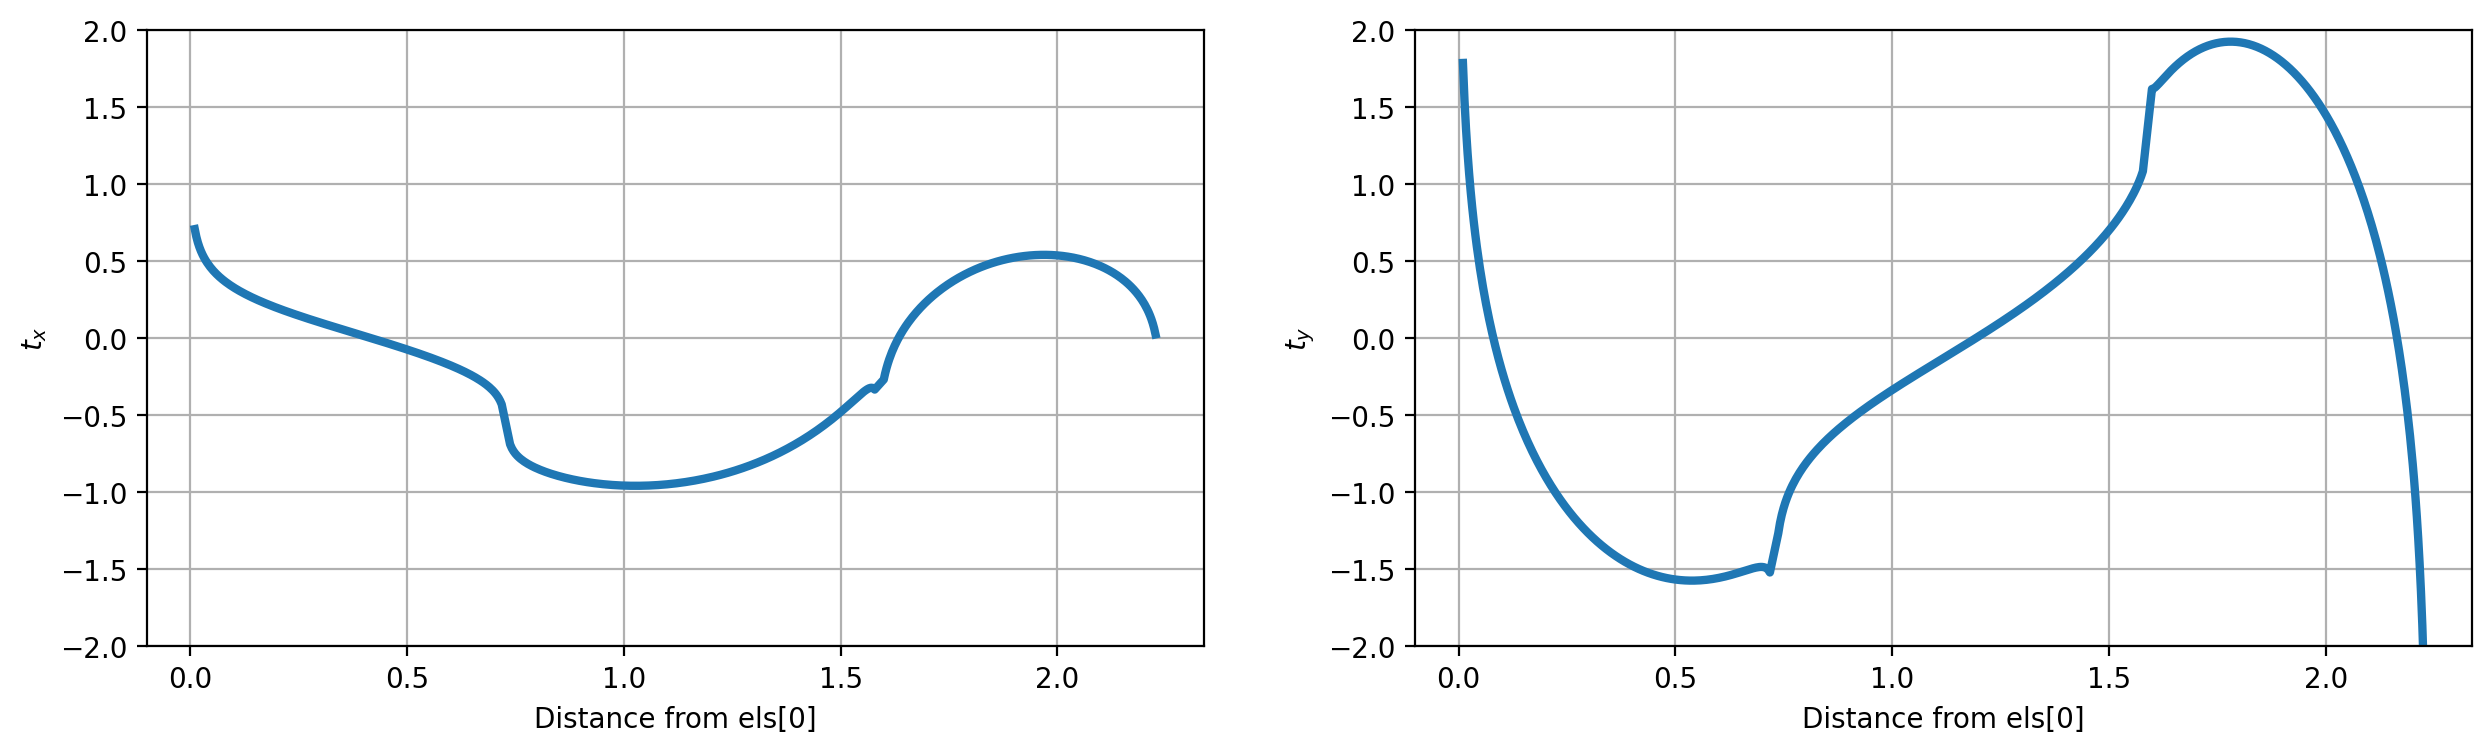

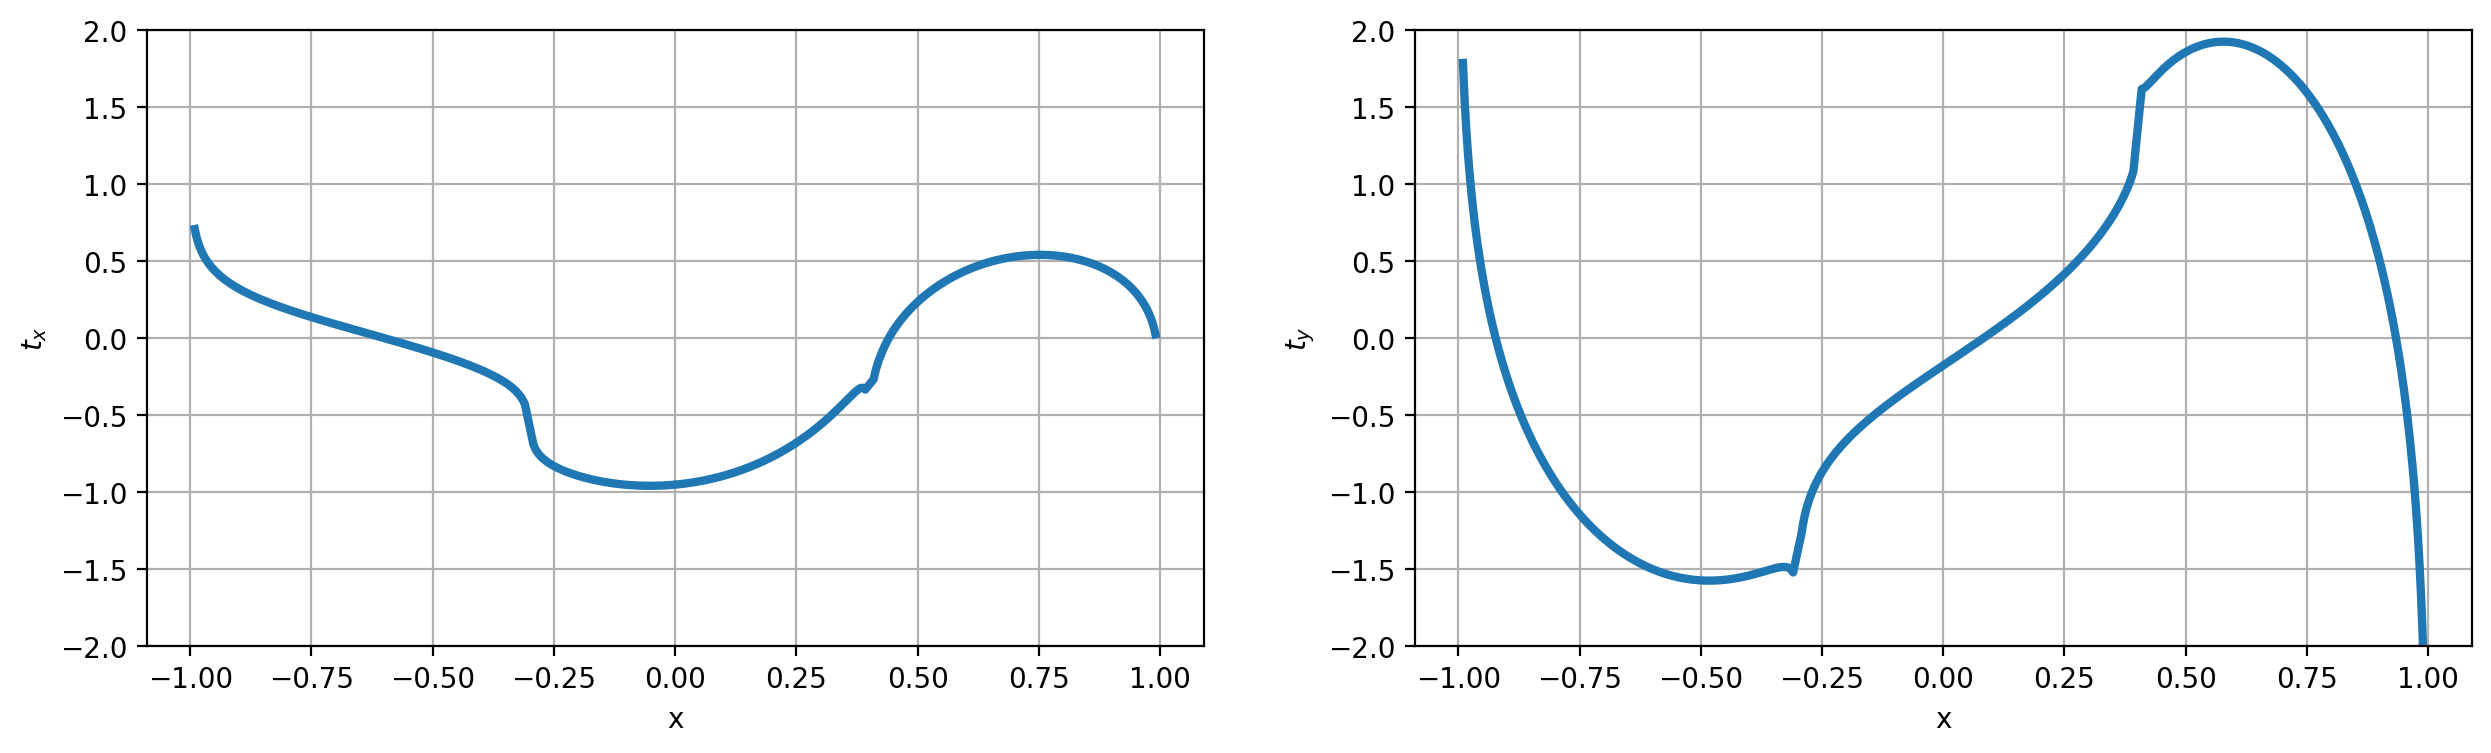

In [32]:
# Compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25

# Compute displacements along a line
n_pts = 200
dr = 1e-2

els_obs = els_normals(els, n_pts)

x_obs = np.hstack(
    (
        np.linspace(
            els.x1[0] + dr * els.x_shears[0], els.x2[0] - dr * els.x_shears[0], n_pts
        ),
        np.linspace(
            els.x1[1] + dr * els.x_shears[1], els.x2[1] - dr * els.x_shears[1], n_pts
        ),
        np.linspace(
            els.x1[2] + dr * els.x_shears[2], els.x2[2] - dr * els.x_shears[2], n_pts
        ),
    )
).reshape(-1, 1)
y_obs = np.hstack(
    (
        np.linspace(
            els.y1[0] + dr * els.y_shears[0], els.y2[0] - dr * els.y_shears[0], n_pts
        ),
        np.linspace(
            els.y1[1] + dr * els.y_shears[1], els.y2[1] - dr * els.y_shears[1], n_pts
        ),
        np.linspace(
            els.y1[2] + dr * els.y_shears[1], els.y2[2] - dr * els.y_shears[2], n_pts
        ),
    )
).reshape(-1, 1)

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)

# compute traction kernels
tractionkernels_s = bemcs.get_traction_kernels(els_obs, kernels_s, flag="global")
tractionkernels_n = bemcs.get_traction_kernels(els_obs, kernels_n, flag="global")

# displacements and stresses
ux_p, uy_p, sxx_p, syy_p, sxy_p = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)
# tractions
tx = tractionkernels_s[0] @ coeffs_s + tractionkernels_n[0] @ coeffs_n
ty = tractionkernels_s[1] @ coeffs_s + tractionkernels_n[1] @ coeffs_n

# Plot tractions
r = np.sqrt((x_obs - els.x1[0]) ** 2 + (y_obs - els.y1[0]) ** 2)
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(r, tx, "-", linewidth=3)
plt.grid()
plt.xlabel("Distance from els[0]")
plt.ylabel("$t_x$")
plt.ylim(-2, 2)
plt.subplot(1, 2, 2)
plt.plot(r, ty, "-", linewidth=3)
plt.grid()
plt.xlabel("Distance from els[0]")
plt.ylabel("$t_y$")
plt.ylim(-2, 2)
plt.show()

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, tx, "-", linewidth=3)
plt.grid()
plt.xlabel("x")
plt.ylabel("$t_x$")
plt.ylim(-2, 2)
plt.subplot(1, 2, 2)
plt.plot(x_obs, ty, "-", linewidth=3)
plt.grid()
plt.xlabel("x")
plt.ylabel("$t_y$")
plt.ylim(-2, 2)
plt.show()